In [16]:
%matplotlib inline

import itertools

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

In [17]:
class LinearSystem:
    """Linear/Affine system"""

    def __init__(self, A, origin=None):
        self.A = A
        self.origin = np.zeros(self.dim) if origin is None else np.asarray(origin)

    def forward(self, x):
        return np.dot(self.A, np.asarray(x) - self.origin) + self.origin

    def reverse(self, x):
        return la.solve(self.A, np.asarray(x) - self.origin) + self.origin

    def eig(self):
        """Eigen values and eigen vectors"""
        return la.eig(self.A)

In [18]:
class Ramsey:
    """One-sector Ramsey model"""

    def __init__(self, A, α, ρ):
        self.A, self.α, self.ρ = A, α, ρ

    def f(self, x):
        """Production function"""
        return self.A * x ** self.α

    def U(self, x):
        """Utility from consumption"""
        return np.log(x)

    def u(self, x, y):
        """Reduced form utility"""
        return self.U(self.f(x) - y)

    def is_feasible(self, x, y):
        """Checks feasibility"""
        return x >= 0 and y >= 0 and self.f(x) >= y

    def steady_state(self):
        """Steady state for the model"""
        A, α, ρ = self.A, self.α, self.ρ
        koo = (ρ * α * A) ** (1 / (1 - α))
        return np.array([koo, koo])

    def forward(self, x):
        """Forward evolution"""
        A, α, ρ = self.A, self.α, self.ρ
        return np.array([
            x[1],
            ((1 + ρ * α) * A * x[1] ** α -
             ρ * α * (A ** 2) * (x[1] ** (α - 1)) * (x[0] ** α))
        ])

    def reverse(self, x):
        """Backward evolution"""
        A, α, ρ = self.A, self.α, self.ρ
        return np.array([
            ((((1 + ρ * α) * A * x[0] ** α - x[1]) /
              (ρ * α * A ** 2 * x[0] ** (α - 1))) ** (1 / α)),
            x[0]
        ])

    def jacobian(self, x=None):
        """Returns jacobian matrix"""
        A, α, ρ = self.A, self.α, self.ρ

        def _jacobian(x):
            """Jacobian as a function of state"""
            return  np.array([
                [0, 1],
                [-ρ * ((α * A) ** 2) * ((x[0] * x[1]) ** (α - 1)),
                 (α * (1 + ρ * α) * A * x[0] ** (α - 1) -
                  ρ * α * (α-1) * (A ** 2) * (x[0]**α) * (x[1] ** (α-2)))]
            ])

        if x is None:
            return _jacobian(self.steady_state())
        return _jacobian(x)

In [19]:
def linearize(diffsys, ss):
    """Linearize differentiable system around a steady state"""
    if not np.allclose(diffsys.forward(ss), ss):
        raise ValueError("Not a steady state")
    return LinearSystem(diffsys.jacobian(ss), ss)

In [20]:
class Simulation:
    """Simulation of a dynamical system"""

    def __init__(self, system, x0=None, duration=np.Inf, inverse=False, domain=None):
        self.system = system
        self.x0 = x0
        self.duration = duration
        self.inverse = inverse
        if domain is not None:
            self.domain = domain
        else:
            self.domain = lambda x: True

    def __iter__(self):
        x = self.x0[:]
        tick = self.system.forward if not self.inverse else self.system.reverse
        t = itertools.count()
        while next(t) < self.duration and self.domain(x):
            yield x
            x = tick(x)
        del t

    def reset(self, x0=None, duration=None, inverse=None):
        """Reset simulation parameters"""

        if x0 is not None:
            self.x0 = x0[:]
        if duration is not None:
            self.duration = duration
        if inverse is not None:
            self.inverse = inverse
        return self

    def __repr__(self):
        text = "Simulation({},\n"
        text += "           x0={},\n"
        text += "           duration={})"
        return text.format(
            str(self.system),
            str(self.x0),
            str(self.duration)
        )

In [21]:
def find_initial_near_eqm(linsys, eps=1e-5):
    init_vals = []
    signs = [-1, 1]
    lambdas, V = linsys.eig()
    for i, lambda_ in enumerate(lambdas):
        for sign in signs:
            init_vals.append((lambda_, linsys.origin + sign * eps * V[:, i]))
    return init_vals

In [22]:
def quiver_plot(ax, path, **kwargs):
    options = {
        'scale_units': 'xy',
        'angles': 'xy',
        'scale': 1,
        'width': 0.003,
        'color': 'black'
    }
    options.update(kwargs)
    path = np.asarray(path)
    return ax.quiver(path[:-1, 0], path[:-1, 1],
                     path[1:, 0]-path[:-1, 0], path[1:, 1]-path[:-1, 1], **options)

In [23]:
ramsey = Ramsey(A=1.2, α=0.4, ρ=0.98)
linearized = linearize(ramsey, ramsey.steady_state())

sim_ramsey = Simulation(ramsey, domain=lambda x: ramsey.is_feasible(*x))
sim_linear = Simulation(linearized)

fig = plt.figure()
ax = fig.add_subplot(111)

kmax = 1.8 * ramsey.steady_state()[0]
k = np.linspace(0.0, kmax, 200)
ax.plot(k, ramsey.f(k), color='black')
ax.fill_between(k, ramsey.f(k), 0.0, color='black', alpha=0.1)
ax.plot(k, k, color='black', linestyle='dashed')

init_vals = find_initial_near_eqm(linearized, eps=1e-6)
for lambda_, inits in init_vals:
    if abs(lambda_) < 1:
        path = list(sim_linear.reset(inits, 15, inverse=True))
        path.reverse()
    else:
        path = list(sim_linear.reset(inits, 20, inverse=False))
    quiver_plot(ax, path, width=0.004, color='black')

for lambda_, inits in init_vals:
    if abs(lambda_) < 1:
        path = list(sim_ramsey.reset(inits, 16, inverse=True))
        path.reverse()
    else:
        path = list(sim_ramsey.reset(inits, 16, inverse=False))
    quiver_plot(ax, path, width=0.004, color='red')

ax.set_xlim([0, kmax])
ax.set_ylim([0, ramsey.f(k[-1])])
plt.show()

In [42]:
def plot_ramsey(A, α, ρ):
    ramsey = Ramsey(A, α, ρ)
    linearized = linearize(ramsey, ramsey.steady_state())

    sim_ramsey = Simulation(ramsey, domain=lambda x: ramsey.is_feasible(*x))
    sim_linear = Simulation(linearized)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    kmax = 1.8 * ramsey.steady_state()[0]
    k = np.linspace(0.0, kmax, 200)
    ax.plot(k, ramsey.f(k), color='black')
    ax.fill_between(k, ramsey.f(k), 0.0, color='black', alpha=0.1)
    ax.plot(k, k, color='black', linestyle='dashed')

    init_vals = find_initial_near_eqm(linearized, eps=1e-6)
    for lambda_, inits in init_vals:
        if abs(lambda_) < 1:
            path = list(sim_linear.reset(inits, 15, inverse=True))
            path.reverse()
        else:
            path = list(sim_linear.reset(inits, 20, inverse=False))
        quiver_plot(ax, path, width=0.004, color='black')

    for lambda_, inits in init_vals:
        if abs(lambda_) < 1:
            path = list(sim_ramsey.reset(inits, 16, inverse=True))
            path.reverse()
        else:
            path = list(sim_ramsey.reset(inits, 16, inverse=False))
        quiver_plot(ax, path, width=0.004, color='red')

    ax.set_xlim([0, kmax])
    ax.set_ylim([0, ramsey.f(k[-1])])
    plt.show()

In [43]:
plot_ramsey(1.1, 0.35, 0.9)

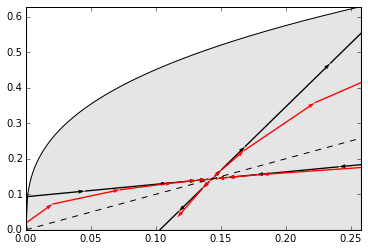

In [44]:
plot_ramsey(1.01, 0.35, 0.8)

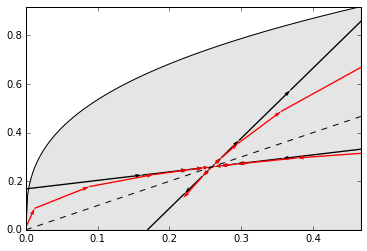

In [45]:
plot_ramsey(1.2, 0.35, 0.99)